### Analysis of Northeast Indian + Nepali samples to delineate migration patterns in the Himalayan region

In [127]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import numpy as np
from datetime import date
import pkg_resources
from sklearn.impute import SimpleImputer
from pandas_plink import read_plink
from copy import deepcopy
import itertools as it
import statsmodels.api as sm
from scipy.stats.distributions import chi2
from random import choices
import scipy as sp
import networkx as nx
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import haversine_distances, pairwise_distances

# viz
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import seaborn as sns
import plotly.express as px
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# feems
import sys
sys.path.append('../../')
from feems.utils import prepare_graph_inputs
from feems.spatial_graph import query_node_attributes
from feems import SpatialGraph, Viz, Objective
from feems.cross_validation import run_cv, comp_mats, run_cv_joint
from feems.utils import cov_to_dist, benjamini_hochberg
from feems.joint_ver import FEEMSmix_SpatialGraph, FEEMSmix_Objective

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["axes.axisbelow"] = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Reading in the data and creating the grid objects (choosing resolution, etc.)

In [63]:
# os.chdir("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/NEI/data")
# (bim, fam, G) = read_plink("FEEMS_noEA_pruned")

## need to create a .coord file with # of rows = # of samples and 2 columns (Longitude, Latitude)
# poplocs = pd.read_csv('poplist_FEEMS_v3.csv')
# indlocs = np.zeros((fam.shape[0],2))
# for i in range(fam.shape[0]):
#     indlocs[i,:] = poplocs.loc[poplocs['Location'] == fam['fid'][i], ['Lon', 'Lat']]
# np.savetxt('indlist.coords', indlocs, delimiter='\t')
# coord = np.loadtxt("indlist.coords")
# coord = np.loadtxt("indlist_noEA.coords")
# outer = np.loadtxt("outer.coords")
# grid_path = "/Users/vivaswatshastry/src/feems/feems/data/grid_100.shp"
grid_path = "/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/59-Ursus_Example/world_triangle_res7.shp"

# np.savetxt('indlist_noEA.coords', indlocs[np.where(~fam['fid'].isin(['Japanese','CHB','Korean']))[0]], delimiter='\t')

outer, edges, grid, _ = prepare_graph_inputs(coord=coord, 
                                             ggrid=grid_path,
                                             translated=False, 
                                             buffer=1,
                                             outer=None)

/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


## Imputing genotypes as $\texttt{FEEMS}$ cannot do missing values

In [5]:
# imp = SimpleImputer(missing_values=np.nan, strategy="mean")
# genotypes = imp.fit_transform((np.array(G)).T)
# genotypes = np.delete(genotypes,np.where(genotypes.sum(axis=0)==2*genotypes.shape[0])[0],1)
# genotypes = np.delete(genotypes,np.where(genotypes.sum(axis=0)==0)[0],1)
# print("n_samples={}, n_snps={}".format(genotypes.shape[0], genotypes.shape[1]))

## subsampling to 50k SNPs for initial run
# genotypes_sub = genotypes[:,np.random.choice(np.arange(genotypes.shape[1]),10000,replace=False)]
# genotypes_sub = np.delete(genotypes_sub,np.where(genotypes_sub.sum(axis=0)==0)[0],1)
# genotypes_sub = np.delete(genotypes_sub,np.where(genotypes_sub.sum(axis=0)==2*genotypes_sub.shape[0])[0],1)

# genotypes_sub2 = genotypes[:,np.random.choice(np.arange(genotypes.shape[1]),200000,replace=False)]
# genotypes_sub2 = np.delete(genotypes_sub2,np.where(genotypes_sub2.sum(axis=0)==0)[0],1)
# genotypes_sub2 = np.delete(genotypes_sub2,np.where(genotypes_sub2.sum(axis=0)==2*genotypes_sub2.shape[0])[0],1)

n_samples=1025, n_snps=90014


## Creating the *sp_graph* object using the grid, edges and genotypes

In [64]:
sp_graph = FEEMSmix_SpatialGraph(genotypes, coord, grid, edges)

## Running the LOO-CV scheme across both $\lambda$ and $\lambda_q$

Text(0, 0.5, 'LOO-CV error')

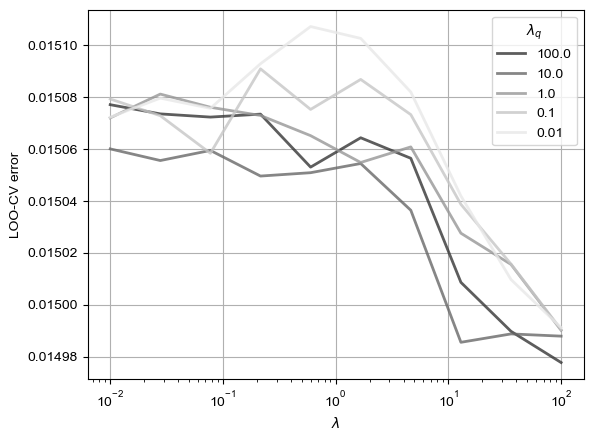

In [203]:
# lamb_grid = np.geomspace(1e-2,1e2,10,endpoint=True)[::-1]; lamb_q_grid = np.geomspace(1e-2,1e2,5,endpoint=True)[::-1]
# cv_err = run_cv_joint(sp_graph, lamb_grid, lamb_q_grid, n_folds=10, factr=1e10)
# mean_cv_err = np.mean(cv_err, axis=0)
# lamb_q_cv = lamb_q_grid[np.where(mean_cv_err == np.min(mean_cv_err))[0][0]]
# lamb_cv = lamb_grid[np.where(mean_cv_err == np.min(mean_cv_err))[1][0]]

plt.gca().set_prop_cycle(color=[plt.get_cmap('Greys_r').resampled(len(lamb_q_grid)+2)(i) for i in range(1,len(lamb_q_grid)+1)])
lineObj = plt.plot(lamb_grid, mean_cv_err.T, linewidth=2, alpha=0.8)
plt.legend(lineObj, lamb_q_grid, title=r'$\lambda_q$'); plt.grid(); plt.xlabel(r'$\lambda$'); plt.semilogx(); plt.ylabel('LOO-CV error')

In [176]:
# spgraph = SpatialGraph(genotypes, indlocs, grid, edges)
# %time spgraph.fit(lamb=400.)
 
# fig = plt.figure(dpi=200)
# ax = fig.add_subplot(1, 1, 1, projection=projection)  
# v = Viz(ax, spgraph, projection=projection, edge_width=.5, edge_alpha=1, edge_zorder=100, sample_pt_size=10, obs_node_textsize=5, obs_node_size=1.5, sample_pt_color="black", cbar_ticklabelsize=8, cbar_width=0.5, cbar_height=0.1, cbar_font_size=8)
# v.draw_map(latlong=[[20,25,30,35],[70,80,90,100]]); v.draw_samples(); v.draw_edges(use_weights=True); v.draw_obs_nodes(use_ids=False); v.draw_edge_colorbar()

## Baseline fit using the LOO-CV $\lambda$ values

In [86]:
%time sp_graph.fit(lamb=lamb_cv*10, optimize_q='n-dim', lamb_q=lamb_q_cv*10)
obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False)

constant-w/variance fit, converged in 153 iterations, train_loss=-8249991.903
lambda=1000.000, alpha=0.0496, converged in 284 iterations, train_loss=-8617869.987
CPU times: user 10.2 s, sys: 1.29 s, total: 11.5 s
Wall time: 4.47 s


## Baseline $\texttt{FEEMS}$ map 

/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.inte

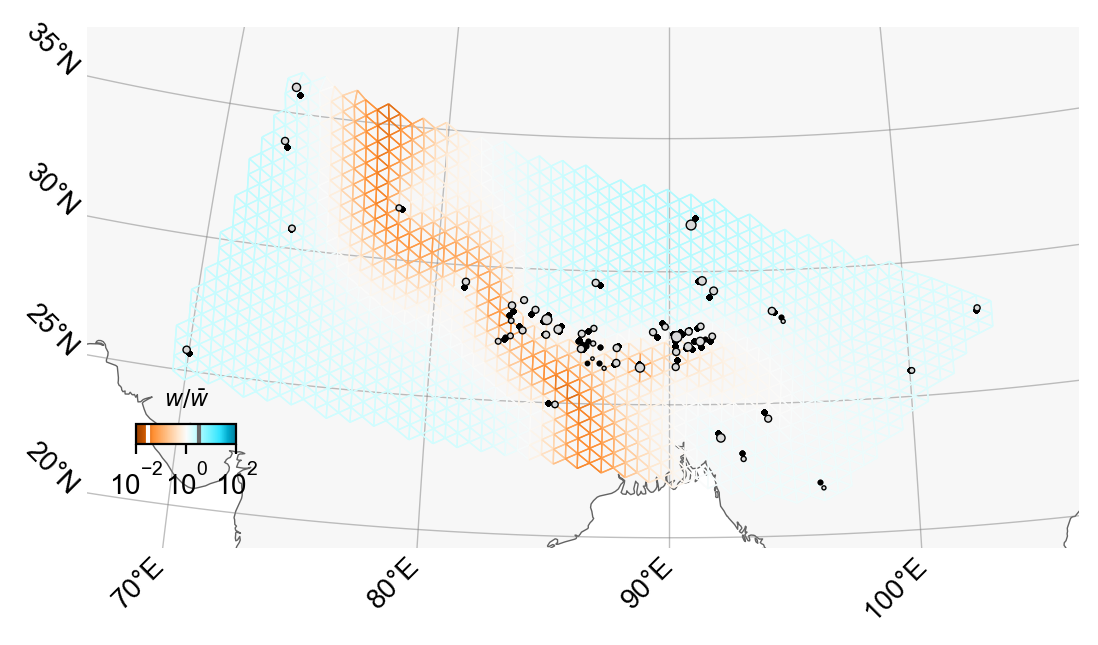

In [84]:
projection = ccrs.AzimuthalEquidistant(central_longitude=90, central_latitude=23)   
fig = plt.figure(dpi=200)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, edge_alpha=1, edge_zorder=100, sample_pt_size=10, obs_node_textsize=5, obs_node_size=1.5, sample_pt_color="black", cbar_ticklabelsize=10, cbar_width=0.5, cbar_height=0.1, cbar_font_size=8, abs_max=2)
v.draw_map(latlong=[[20,25,30,35],[70,80,90,100]])
v.draw_samples(); v.draw_edges(use_weights=True); v.draw_obs_nodes(use_ids=False); v.draw_edge_colorbar()
## plt.savefig('../results/noEA_ndim_lamb30.pdf', bbox_inches='tight')
# v.ax.add_feature(cartopy.feature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines', scale='110m', facecolor='none', edgecolor='grey'))
# obs_grid = v.grid[query_node_attributes(sp_graph, "permuted_idx")[: sp_graph.n_observed_nodes],:]

## Basic fit with $R^2$ + outlier plot

constant-w/variance fit, converged in 153 iterations, train_loss=-8249991.903
constant-w/variance fit, converged in 153 iterations, train_loss=-8249991.903
lambda=100.000, alpha=0.0496, converged in 417 iterations, train_loss=-8838068.478


Text(0, 0.5, 'genetic distance')

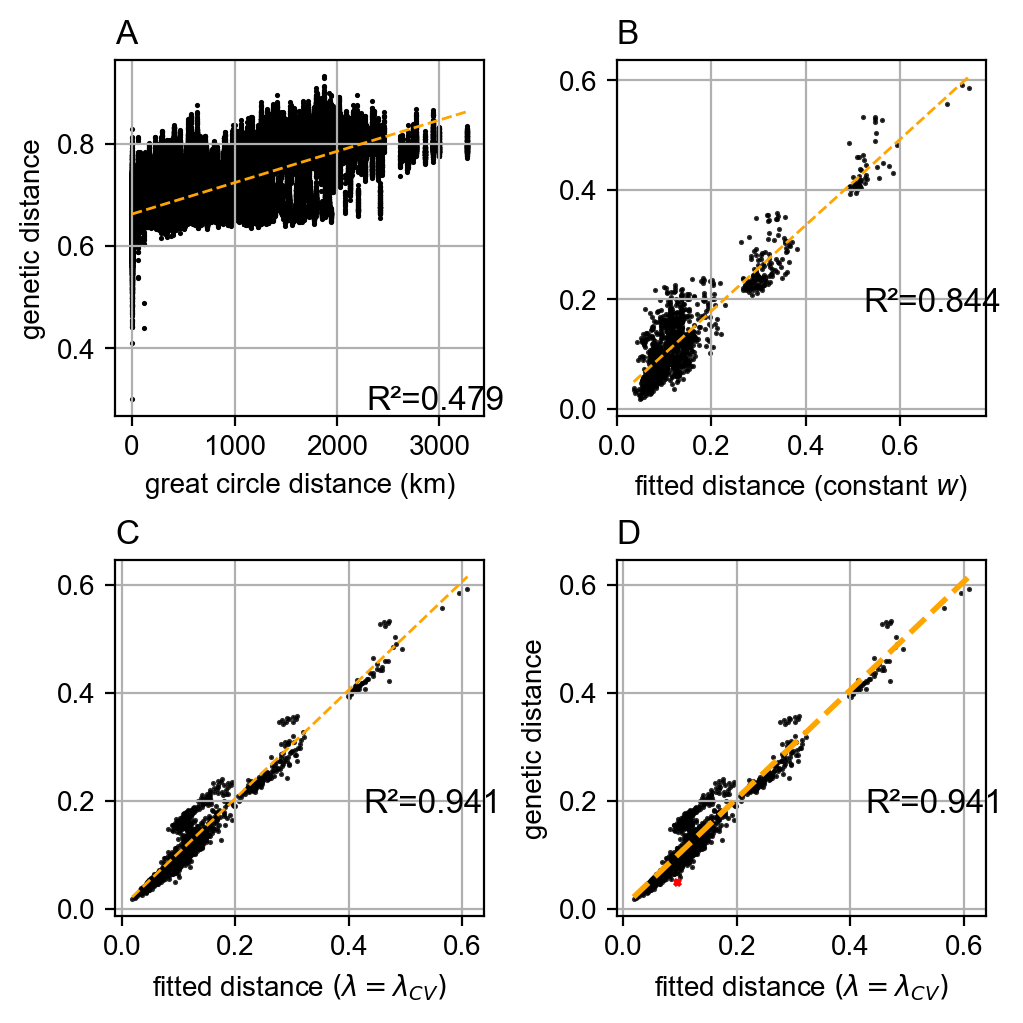

In [131]:
from matplotlib import gridspec
fig = plt.figure(constrained_layout=True, dpi=200, figsize=(5, 5))
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

# (A) Genetic distance vs geographic distance
## takes very long to compute!
# D_geno = squareform(pdist(sp_graph.genotypes, metric="sqeuclidean")) / sp_graph.n_snps
coord_rad = coord[:,::-1] * np.math.pi / 180.0
D_geo = haversine_distances(coord_rad) * 6371000/1000
tril_idx = np.tril_indices(sp_graph.genotypes.shape[0], k=-1)
x = D_geo[tril_idx]
y = D_geno[tril_idx]
X = sm.add_constant(x)
mod = sm.OLS(y, X)
res = mod.fit()
muhat, betahat = res.params

ax_00 = fig.add_subplot(spec[0, 0])
ax_00.set_title("A", loc='left'); ax_00.grid()
ax_00.scatter(x, y, marker=".", alpha=1, zorder=0, color="black", s=3)

x_ = np.linspace(np.min(x), np.max(x), 20)
ax_00.plot(x_, muhat + betahat * x_, zorder=2, color="orange", linestyle='--', linewidth=1.5); 
ax_00.text(0.7*np.max(x), 0.5*np.max(y), "R²={:.3f}".format(res.rsquared), size='large')
ax_00.set_xlabel("great circle distance (km)")
ax_00.set_ylabel("genetic distance")

# (B) Genetic distance vs fitted distance for constant w model 
tril_idx = np.tril_indices(sp_graph.n_observed_nodes, k=-1)
ax_01 = fig.add_subplot(spec[0, 1]); ax_01.grid()
ax_01.set_title("B", loc='left')
sp_graph.fit_null_model()
sp_graph.comp_graph_laplacian(sp_graph.w)

obj = FEEMSmix_Objective(sp_graph)
fit_cov, _, emp_cov = comp_mats(obj)
fit_dist = cov_to_dist(fit_cov)[tril_idx]
emp_dist = cov_to_dist(emp_cov)[tril_idx]
X = sm.add_constant(fit_dist)
mod = sm.OLS(emp_dist, X)
res = mod.fit()
muhat, betahat = res.params
ax_01.scatter(fit_dist, emp_dist, marker=".", alpha=0.8, zorder=0, color="k", s=3)
x_ = np.linspace(np.min(fit_dist), np.max(fit_dist), 20)
ax_01.plot(x_, muhat + betahat * x_, zorder=2, color="orange", linestyle='--', linewidth=1.5)
ax_01.text(0.6*np.max(fit_dist), 0.2*np.max(emp_dist), "R²={:.3f}".format(res.rsquared), size='large')
ax_01.set_xlabel(r"fitted distance (constant $w$)"); ax_01.set_ylabel('genetic distance')

# (C) Genetic distance vs fitted distance for lambda = lambda_cv
tril_idx = np.tril_indices(sp_graph.n_observed_nodes, k=-1)
ax_10 = fig.add_subplot(spec[1, 0])
ax_10.set_title("C", loc='left'); ax_10.grid()
lamb = lamb_cv
sp_graph.fit(lamb=lamb, lb=np.math.log(1e-6), ub=np.math.log(1e+6))
sp_graph.comp_graph_laplacian(sp_graph.w)

obj = FEEMSmix_Objective(sp_graph)
fit_cov, _, emp_cov = comp_mats(obj)
fit_dist = cov_to_dist(fit_cov)[tril_idx]
emp_dist = cov_to_dist(emp_cov)[tril_idx]
X = sm.add_constant(fit_dist)
mod = sm.OLS(emp_dist, X)
res = mod.fit()
muhat, betahat = res.params
ax_10.scatter(fit_dist, emp_dist, marker=".", alpha=0.8, zorder=0, color="k", s=3)
x_ = np.linspace(np.min(fit_dist), np.max(fit_dist), 20)
ax_10.plot(x_, muhat + betahat * x_, zorder=2, color="orange", linestyle='--', linewidth=1.5)
ax_10.text(0.6*np.max(fit_dist), 0.2*np.max(emp_dist), "R²={:.3f}".format(res.rsquared), size='large')
ax_10.set_xlabel("fitted distance $(\lambda = \lambda_{CV})$"); ax_10.set_ylabel('genetic distance')

# (D) Genetic distance vs fitted distance for lambda = lambda_cv WITH outliers
ax_11 = fig.add_subplot(spec[1, 1])
ax_11.set_title("D", loc='left'); ax_11.grid()

fit_cov, _, emp_cov = comp_mats(obj)
fit_dist = cov_to_dist(fit_cov)[tril_idx]
emp_dist = cov_to_dist(emp_cov)[tril_idx]
X = sm.add_constant(fit_dist)
mod = sm.OLS(emp_dist, X)
res = mod.fit()
muhat, betahat = res.params
ax_11.scatter(fit_dist, emp_dist, marker=".", alpha=0.8, zorder=0, color="k", s=3)
bh = benjamini_hochberg(emp_dist, fit_dist, fdr=0.25)
ax_11.scatter(fit_dist[bh],emp_dist[bh],marker='x',color='r',s=5)
x_ = np.linspace(np.min(fit_dist), np.max(fit_dist), 20); 
ax_11.plot(x_, muhat + betahat * x_, zorder=2, color="orange", linestyle='--', linewidth=1.5);
ax_11.text(0.6*np.max(fit_dist), 0.2*np.max(emp_dist), "R²={:.3f}".format(res.rsquared), size='large')
ax_11.set_xlabel("fitted distance $(\lambda = \lambda_{CV})$"); ax_11.set_ylabel("genetic distance")

## Extracting outliers at a $\text{FDR}=0.25$ level & plotting the outlier demes

In [140]:
# outliers_df = obj.extract_outliers(fdr=0.25, verbose=True)
print(outliers_df)

# fig = plt.figure(dpi=200)
# ax = fig.add_subplot(1, 1, 1, projection=projection)  
# v = Viz(ax, sp_graph, projection=projection, edge_width=.5, edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
#         obs_node_textsize=5, obs_node_size=1.5, sample_pt_color="black", cbar_ticklabelsize=10, cbar_width=0.5, 
#         cbar_height=0.1, cbar_font_size=8, abs_max=2)
# v.draw_map(latlong=[[20,25,30,35],[70,80,90,100]])
# v.draw_samples(); v.draw_obs_nodes(use_ids=True); 
# for dest in np.unique(outliers_df['dest.']):
#     v.ax.plot(v.grid[dest, 0], v.grid[dest, 1], 'o', color='dodgerblue', markersize=20*np.log10(np.sum(outliers_df['dest.']==dest)+1), alpha=0.5)

,source,dest.,"source (lat., long.)","dest. (lat., long.)",pval,raw diff.,Fst
4,138,613,"(24.942, 85.283)","(35.954, 72.87)",0.000004,-0.093712,0.003798
1,6,613,"(24.942, 85.283)","(25.764, 69.896)",0.000045,-0.085723,0.003100
2,113,613,"(24.942, 85.283)","(33.927, 72.734)",0.000167,-0.081311,0.004537
3,129,613,"(24.942, 85.283)","(30.746, 73.589)",0.000458,-0.077228,0.002229
0,138,6,"(35.954, 72.87)","(25.764, 69.896)",0.000874,-0.039656,0.002481


## Plotting the contours for each putative destination deme

/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.inte

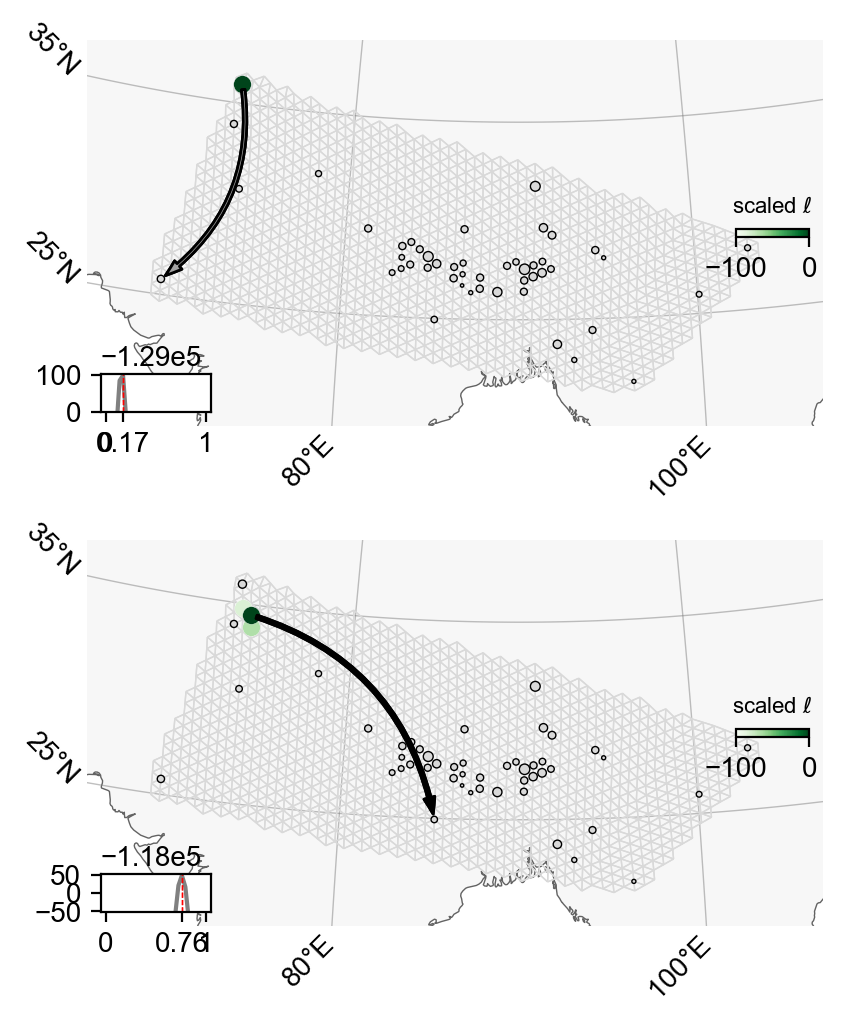

In [142]:
# contour_df = {}
# for dest in np.unique(outlier_df['dest.']):
#     contour_df[dest] = obj.calc_contour(destid = dest, search_area = 'all')

fig = plt.figure(constrained_layout=True, dpi=200)
for i, dest in enumerate(np.unique(outlier_df['dest.'])):
    ax = fig.add_subplot(len(np.unique(outlier_df['dest.'])), 1, i+1, projection=projection)  
    v = Viz(ax, sp_graph, projection=projection, edge_width=.5, edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
            obs_node_textsize=5, obs_node_size=1.5, sample_pt_color="black", cbar_ticklabelsize=10, 
            cbar_width=0.5, cbar_height=0.1, cbar_font_size=8, abs_max=2)
    v.draw_map(latlong=[[25,35],[80,100]]); v.draw_edges(); v.draw_obs_nodes(use_ids=False); 
    v.draw_ll_contour(contour_df[dest], levels=[-100])
    v.draw_arrow([contour_df[dest]['(source, dest.)'].iloc[np.argmax(contour_df[dest]['scaled log-lik'])]], 
                contour_df[dest]['admix. prop.'].iloc[np.argmax(contour_df[dest]['scaled log-lik'])])

## Running a sequential fit on the data

([<matplotlib.axis.XTick at 0x169e8ad40>,
 [Text(0, 0, 'baseline'), Text(1, 0, '1')])

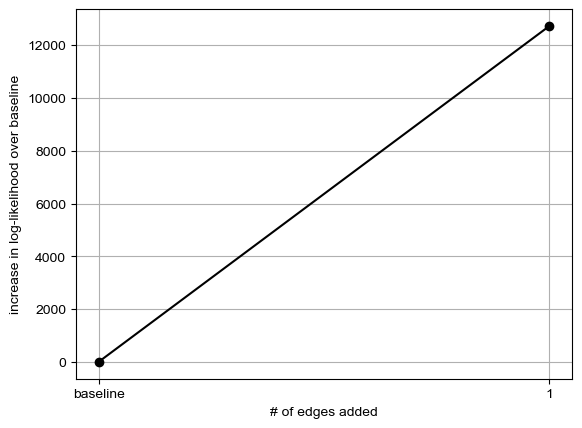

In [200]:
# seq_results = sp_graph.sequential_fit(fdr = 0.5)
# seq_results

plt.plot(range(len(seq_results)), [seq_results[i]['log-lik']-seq_results[0]['log-lik'] for i in range(len(seq_results))], '-ko'); plt.grid()
plt.ylabel('increase in log-likelihood over baseline'); plt.xlabel('# of edges added'); plt.xticks(ticks=range(len(seq_results)),labels=['baseline']+list(range(1,len(seq_results))))

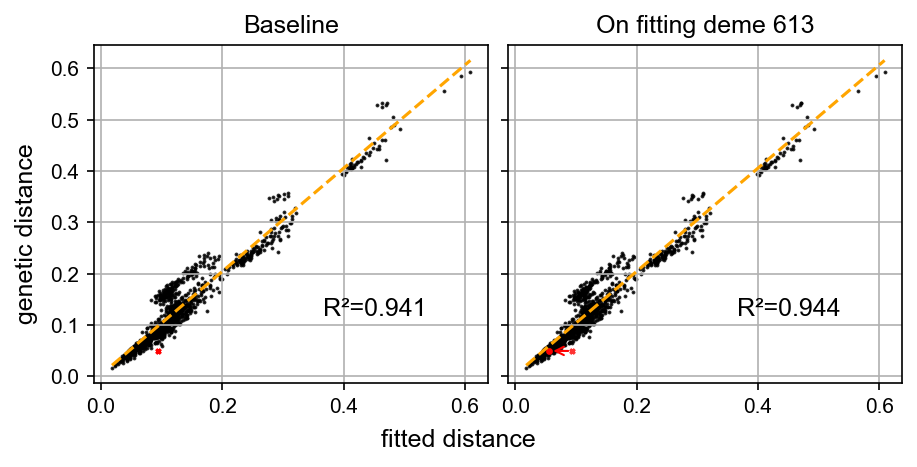

In [204]:
fig, axs = plt.subplots(1, len(seq_results), dpi=150, figsize=(6,3), sharey=True, constrained_layout=True)
# plt.ylabel('genetic distance'); plt.xlabel('fitted distance')
X = sm.add_constant(seq_results[0]['fit_dist'])
mod = sm.OLS(seq_results[0]['emp_dist'], X)
res = mod.fit()
muhat, betahat = res.params
axs[0].grid(); 
axs[0].scatter(seq_results[0]['fit_dist'], seq_results[0]['emp_dist'], marker=".", alpha=0.8, zorder=0, color="k", s=3)
bh = benjamini_hochberg(seq_results[0]['emp_dist'], seq_results[0]['fit_dist'], fdr=seq_results[0]['fdr'])
axs[0].scatter(seq_results[0]['fit_dist'][bh], seq_results[0]['emp_dist'][bh], marker='x', color='r', s=5)
x_ = np.linspace(np.min(seq_results[0]['fit_dist']), np.max(seq_results[0]['fit_dist']), 20); 
axs[0].plot(x_, muhat + betahat * x_, zorder=2, color="orange", linestyle='--', linewidth=1.5);
axs[0].text(0.6, 0.2, "R²={:.3f}".format(res.rsquared), transform=axs[0].transAxes, size='large')
axs[0].set_title('Baseline')
fig.supxlabel('fitted distance'); fig.supylabel('genetic distance');
for i in range(1,len(seq_results)):
    X = sm.add_constant(seq_results[i]['fit_dist'])
    mod = sm.OLS(seq_results[0]['emp_dist'], X)
    res = mod.fit()
    muhat, betahat = res.params
    axs[i].scatter(seq_results[i]['fit_dist'], seq_results[0]['emp_dist'], marker=".", alpha=0.8, zorder=0, color="k", s=3)
    axs[i].scatter(seq_results[i]['fit_dist'][bh], seq_results[0]['emp_dist'][bh], marker='o', color='r', s=5)
    axs[i].scatter(seq_results[i-1]['fit_dist'][bh], seq_results[0]['emp_dist'][bh], marker='x', color='r', s=5, alpha=0.8)
    for il in range(np.sum(bh)):
        # axs[i].plot((seq_results[i]['fit_dist'][bh][il], seq_results[i-1]['fit_dist'][bh][il]), 
        #             (seq_results[0]['emp_dist'][bh][il], seq_results[0]['emp_dist'][bh][il]), color='r', linewidth=1)
        axs[i].annotate('',  # No text
            xy=(seq_results[i-1]['fit_dist'][bh][il], seq_results[0]['emp_dist'][bh][il]),  # Arrow end (head)
            xytext=(seq_results[i]['fit_dist'][bh][il], seq_results[0]['emp_dist'][bh][il]),  # Arrow start (tail)
            arrowprops=dict(arrowstyle="<-", color='r', linewidth=1))
    x_ = np.linspace(np.min(seq_results[i]['fit_dist']), np.max(seq_results[i]['fit_dist']), 20); 
    axs[i].plot(x_, muhat + betahat * x_, zorder=2, color="orange", linestyle='--', linewidth=1.5); axs[i].grid()
    axs[i].text(0.6, 0.2, "R²={:.3f}".format(res.rsquared), transform=axs[i].transAxes, size='large')
    axs[i].set_title('On fitting deme {:d}'.format(seq_results[i]['deme']))

/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shap

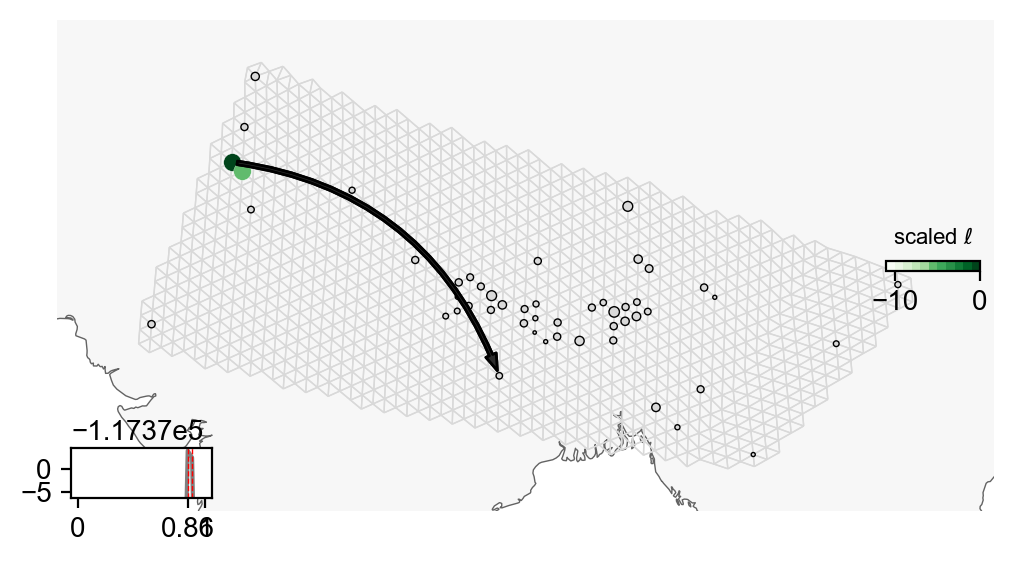

In [201]:
fig = plt.figure(constrained_layout=True, figsize=(5,5), dpi=200)
for i in range(1,len(seq_results)):
    ax = fig.add_subplot(len(seq_results), 1, i+1, projection=projection)  
    v = Viz(ax, sp_graph, projection=projection, edge_width=.5, edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
            obs_node_textsize=5, obs_node_size=1.5, sample_pt_color="black", cbar_ticklabelsize=10, 
            cbar_width=0.5, cbar_height=0.1, cbar_font_size=8, abs_max=2)
    v.draw_map(latlong=False); v.draw_edges(); v.draw_obs_nodes(use_ids=False); 
    v.draw_ll_contour(seq_results[i]['contour_df'], levels=[-10])
    v.draw_arrow([seq_results[i]['contour_df']['(source, dest.)'].iloc[np.argmax(seq_results[i]['contour_df']['scaled log-lik'])]], 
                seq_results[i]['contour_df']['admix. prop.'].iloc[np.argmax(seq_results[i]['contour_df']['scaled log-lik'])])